## 6B. Generating Input

In Section 6A we used BMTK's ```NetworkBuilder``` built a reduced model of the mouse visual cortex which was saved in the **network/** directory. And in the rest of the Chapter we want to use the ```PointNet``` simulator to run multiple simulations of the network. But before we can do that we will want generate spike-train data that can be use to drive the simulation, which we will procede to do in this Section.

Generating input spike-trains for the model can require a fair amount of time and computation (expect ~10-30 minutes to generate visual stimulus inputs for LGN). As such we have already saved input spike-trains into the **inputs/** directory. However should one need to re-generate inputs (in the cases the LGN node coordinates have been updated) or if you want to create additional input, please proceed.

Here we will be using ```FilterNet```, the basics of which which were already covered in a previous chapter.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from bmtk.utils import sonata

### LGN Inputs

The main driver of the system is the "lgn" network we created in the previous section. The "lgn" nodes consists of cells with properties that mimic the various types of cells found in the mammalian visual thalamic area. Using ```FilterNet``` we can man various types of visual stimuli onto the lgn receptive field generating realistic responses. Then uses those responses to drive the main visual cortex network.

First let us use bmtk.utils.sonata to determine the make-up and distribution of our LGN model:

In [5]:
net = sonata.File(
    data_files='network/lgn_nodes.h5',
    data_type_files='network/lgn_node_types.csv'
)
lgn_nodes_df = net.nodes['lgn'].to_dataframe(index_by_id=False)
lgn_nodes_df['node_count'] = 1
lgn_nodes_df[['model_name', 'model_template', 'node_count']].groupby(['model_name', 'model_template']).agg('count')

,,node_count
model_name,model_template,
sOFF_TF1,lgnmodel:sOFF_TF1,1200
sOFF_TF15,lgnmodel:sOFF_TF15,1050
sOFF_TF2,lgnmodel:sOFF_TF2,1200
sOFF_TF4,lgnmodel:sOFF_TF4,2250
sOFF_TF8,lgnmodel:sOFF_TF8,1200
sON_TF1,lgnmodel:sON_TF1,1050
sON_TF2,lgnmodel:sON_TF2,750
sON_TF4,lgnmodel:sON_TF4,1050
sON_TF8,lgnmodel:sON_TF8,2250


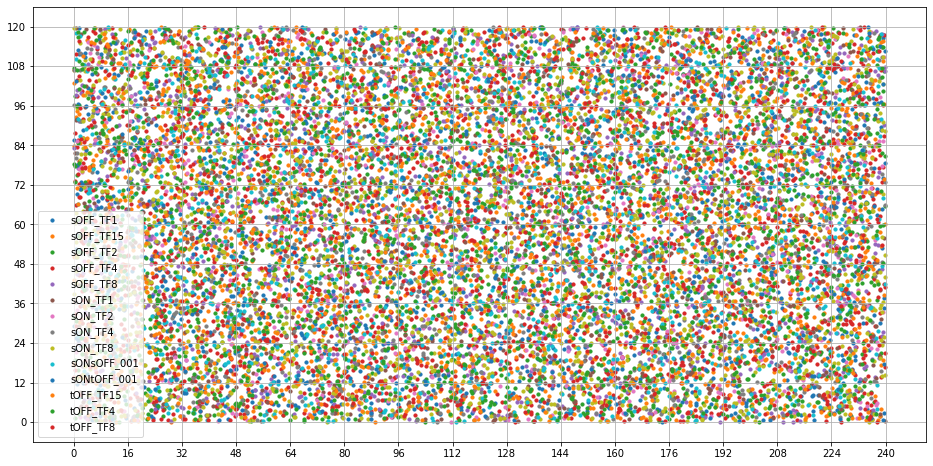

In [16]:
x_grids = 15
y_grids = 10
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for model_name, model_df in lgn_nodes_df.groupby('model_name'):
    ax.scatter(model_df['x'].values, model_df['y'].values, s=10, label=model_name)

ax.set_xticks(np.arange(0, size[0]+x_grids, size[0]/x_grids))
ax.set_yticks(np.arange(0, size[1]+y_grids, size[1]/y_grids))
ax.legend()
ax.grid()

#### FilterNet Config(s)

We will start with a moving grating running at a 90 degree angle at a rate of 4.0Hz, with a 500.0 milisecond grey-screen at the start. Update the ```config.simulation_filternet.dg_90deg_4Hz.json``` in the inputs sections:

```json
  "inputs": {
    "gratings": {
      "input_type": "movie",
      "module": "graiting",
      "row_size": 120,
      "col_size": 240,
      "gray_screen_dur": 500.0,
      "cpd": 0.04,
      "temporal_f": 4.0,
      "contrast": 0.8,
      "theta": 90.0,
      "evaluation_options": {
        "downsample": 1,
        "separable": true
      }
    }
  },
```

To make things easier, instead of saving the results into the **output/** directory, it will be saved into the **inputs/** directory. This is because we want to use these results as the inputs into our ```PointNet``` visual cortex model. 

Note that we are actually saving a couple of files; the *rates* file contain the raw firing-rate traces for each individual LGN cell in hdf5 format. ```FilterNet``` uses this rates and a Poisson process to convert the heterogeneous firing rates into individual spikes and saves it in *spikes_file* in SONATA format.

```json
   "output":{
     "log_file": "log.txt",
     "output_dir": "./inputs",
     "rates_h5": "rates.gratings.dg_90deg_4Hz.h5",
     "spikes_file": "spikes.gratings.dg_90deg_4Hz.h5",
     "spikes_file_csv": "spikes.gratings.dg_90deg_4Hz.csv"
   },
```

#### Running FilterNet simulation

We can generate gratings input to our lgn cells either through the command line, with access to MPI:

```bash
 $ mpirun -np <N> python run_filternet.py config.simulation_filternet.dg_90deg_4Hz.json
```

With some modifications to the script we can run it in the notebook

In [ ]:
from bmtk.simulator import filternet

configs = [
    # drifting gratings at 2 Hz
    'config.simulation_filternet.dg_0deg_2Hz.json',
    'config.simulation_filternet.dg_45deg_2Hz.json',
    'config.simulation_filternet.dg_90deg_2Hz.json',   
    # drifting gratings at 4 Hz
    # 'config.simulation_filternet.dg_0deg_4Hz.json',
    # 'config.simulation_filternet.dg_45deg_4Hz.json',
    # 'config.simulation_filternet.dg_90deg_4Hz.json',
    # Full Field flashes
    # 'config.simulation_filternet.flash_on.json',
    # 'config.simulation_filternet.flash_off.json'
]


for config_file in configs:
    print('Running {}'.format(config_file))
    config = filternet.Config.from_json(config_file)
    config.build_env()

    net = filternet.FilterNetwork.from_config(config)
    sim = filternet.FilterSimulator.from_config(config, net)
    sim.run()
    print(' ')

2022-05-31 15:22:27,597 [WARNING] Directory ./inputs already exists.
2022-05-31 15:22:27,603 [INFO] Created log file
2022-05-31 15:22:28,509 [INFO] Building cells.
2022-05-31 15:33:39,563 [INFO] Evaluating rates.
2022-05-31 15:48:41,333 [INFO] Done.
2022-05-31 15:48:42,797 [WARNING] Directory ./inputs already exists.
2022-05-31 15:48:42,798 [INFO] Created log file
2022-05-31 15:48:43,316 [INFO] Building cells.
2022-05-31 15:59:20,586 [INFO] Evaluating rates.
2022-05-31 16:13:48,519 [INFO] Done.
2022-05-31 16:13:49,995 [WARNING] Directory ./inputs already exists.
2022-05-31 16:13:49,996 [INFO] Created log file
2022-05-31 16:13:50,700 [INFO] Building cells.
